# IMPORTS

## Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colors

## Data

In [2]:
from novelty_detection.data import load_data
data = load_data("banknote_authentication.txt", header_names=['x1', 'x2', 'x3', 'x4', 'y'])
print(data.shape)
data.head()

(1372, 5)


,x1,x2,x3,x4,y
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# PREPROCESSING

In [3]:
X=data[['x1', 'x2', 'x3', 'x4']].to_numpy()
y=data[['y']].to_numpy()

## Split

In [4]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('y train shape: ', train_y.shape) 
print('x test shape: ', test_x.shape)
print('x test shape: ', test_y.shape)

x train shape:  (1097, 4)
y train shape:  (1097, 1)
x test shape:  (275, 4)
x test shape:  (275, 1)


## Scale

In [5]:
from novelty_detection.preprocessing import minmax_scaler
train_x_norm = minmax_scaler(train_x)
test_x_norm = minmax_scaler(test_x)
X_norm = minmax_scaler(X)

# TRAINING

In [16]:
from novelty_detection.som import SOM

model=SOM(som_grid_size=(10,10),
          max_distance=4,
          learning_rate=0.5,
          max_iter=10000,
          random_state=40,
          methods={'init_som': 'uniform',
                    'bmu_distance': 'cityblock',
                    'compute_neighborhood': 'ceil',
                    'update_sigma_and_learning_rate': 'linear'})

model=model.fit_with_iterations(train_x_norm)

## SOM data visualization with PCA

Convert som data (3d array) to data i a dataset structure (every row is a cell from the som matrix)

In [22]:
som=model.som
som_dataset=som.reshape(-1,som.shape[2])

In [23]:
# 2D vizualization
pca = PCA(n_components = 2)
X2D = pca.fit_transform(som_dataset)

# Amount of explained variance kept 2D
exp_variance_2d = pca.explained_variance_ratio_
print(f"2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# 3D vizualization
pca = PCA(n_components = 3)
X3D = pca.fit_transform(som_dataset)

# Amount of explained variance kept 3D
exp_variance_3d = pca.explained_variance_ratio_
print(f"3D: Total = {np.sum(exp_variance_3d)} and per components = {exp_variance_3d}")

2D: Total = 0.9016754679897241 and per components = [0.59852257 0.3031529 ]
3D: Total = 0.9729271586269347 and per components = [0.59852257 0.3031529  0.07125169]


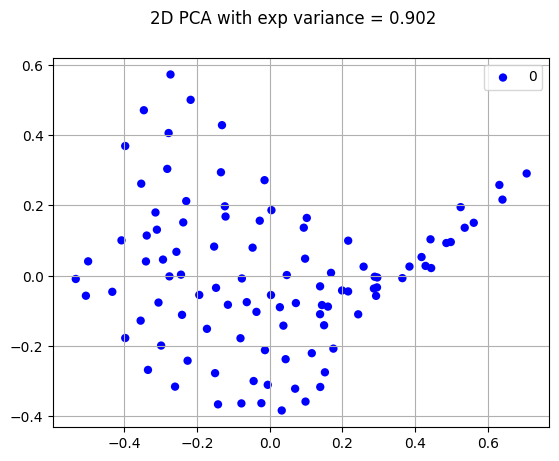

In [24]:
y_flat = y.ravel()

# Plot of the 2D PCA results
fig, ax = plt.subplots()

ax.scatter(X2D[:,0], X2D[:,1], color="blue", label="0", edgecolors='none')

ax.legend()
ax.grid(True)

fig.suptitle(f"2D PCA with exp variance = {round(np.sum(exp_variance_2d), 3)}")

plt.show()

# PREDICT

In [38]:
def find_bmu(X_row, som):
    """
    Find the index of the best matching unit for the input vector X_row.
    """
    # min coordinates are the same for distance and the square of distance 
    distances = np.square(som - X_row).sum(axis=2)
    bmu_coordinates = np.unravel_index(distances.argmin().astype(int), (10,10))
    
    return bmu_coordinates

In [39]:
X_row=test_x_norm[0]
find_bmu(X_row, som)

(1, 6)

In [40]:
X=train_x_norm
som_grid_shape = (10,10)
bmu_counts = np.zeros(shape=som_grid_shape)
for X_row in X:
    bmu = find_bmu(X_row, som)
    bmu_counts[bmu] += 1

bmu_counts

array([[17., 14., 14.,  7., 14.,  2.,  9., 12.,  7., 34.],
       [14., 17.,  7.,  5., 18.,  5., 19.,  5.,  7., 15.],
       [13.,  1., 11., 12.,  7., 10., 15., 15., 12., 10.],
       [12.,  6., 16., 17., 14.,  5.,  8., 10., 10., 13.],
       [ 6.,  9.,  7., 19., 18.,  2., 18., 10., 17., 11.],
       [10.,  2., 27.,  4., 21., 10., 10., 12.,  6.,  8.],
       [ 3., 19.,  0.,  7.,  9.,  2., 13., 12., 13., 11.],
       [19.,  7.,  3., 18.,  1., 17., 13.,  4., 21., 18.],
       [ 6.,  6., 16., 13.,  6.,  5., 10., 10.,  1.,  8.],
       [21.,  3., 12.,  1., 17.,  5., 14., 14., 21., 12.]])

In [41]:
from novelty_detection.utils import (argmin_first_two_axes,
                                     choose_random_sample,
                                     choose_random_array)

#generate a distance map for every X row (every third dim belongs to a row)
som_bro = som[:,:,:,np.newaxis]
data_bro = X.T[np.newaxis,np.newaxis, :, :]
distance_map = np.sqrt(np.sum((som_bro-data_bro)**2, axis=2))
# find the min distance indices for every third dim 
idx=argmin_first_two_axes(distance_map)
unique_idx, counts_idx = np.unique(idx, return_counts=True, axis=0)
occurence_freq_map = np.zeros(shape=(10,10))
occurence_freq_map[unique_idx[:,0], unique_idx[:,1]] = counts_idx
occurence_freq_map

array([[17., 14., 14.,  7., 14.,  2.,  9., 12.,  7., 34.],
       [14., 17.,  7.,  5., 18.,  5., 19.,  5.,  7., 15.],
       [13.,  1., 11., 12.,  7., 10., 15., 15., 12., 10.],
       [12.,  6., 16., 17., 14.,  5.,  8., 10., 10., 13.],
       [ 6.,  9.,  7., 19., 18.,  2., 18., 10., 17., 11.],
       [10.,  2., 27.,  4., 21., 10., 10., 12.,  6.,  8.],
       [ 3., 19.,  0.,  7.,  9.,  2., 13., 12., 13., 11.],
       [19.,  7.,  3., 18.,  1., 17., 13.,  4., 21., 18.],
       [ 6.,  6., 16., 13.,  6.,  5., 10., 10.,  1.,  8.],
       [21.,  3., 12.,  1., 17.,  5., 14., 14., 21., 12.]])

In [58]:
allowed_nodes = som[bmu_counts >= 3]
allowed_nodes

array([[0.18937094, 0.8341777 , 0.24671085, 0.22777765],
       [0.31467903, 0.89357391, 0.24553466, 0.24306523],
       [0.44022121, 0.8678071 , 0.1865205 , 0.23908793],
       [0.49274347, 0.73542756, 0.08022148, 0.31521922],
       [0.52758895, 0.66767327, 0.03938689, 0.38951533],
       [0.56570927, 0.85614646, 0.19586973, 0.49343758],
       [0.62034552, 0.87988694, 0.1566842 , 0.44554613],
       [0.72079557, 0.89587548, 0.08429993, 0.40943896],
       [0.7824161 , 0.89736096, 0.05611604, 0.40993735],
       [0.19818386, 0.80000438, 0.24907753, 0.32904761],
       [0.31919949, 0.86978266, 0.28201638, 0.34353732],
       [0.39961289, 0.8122321 , 0.2154778 , 0.39140435],
       [0.44377311, 0.68408703, 0.13136727, 0.45591463],
       [0.49056987, 0.65085679, 0.08174785, 0.48473545],
       [0.54703872, 0.72759883, 0.12807121, 0.56569187],
       [0.57805204, 0.82880325, 0.19533561, 0.58489017],
       [0.60374025, 0.85306909, 0.16878952, 0.56135656],
       [0.72711083, 0.86637623,

In [59]:
from sklearn.neighbors import NearestNeighbors

classifier = NearestNeighbors(n_neighbors=3)
classifier.fit(allowed_nodes)
dist, _ = classifier.kneighbors(test_x_norm)

dist

array([[0.13004534, 0.13607156, 0.14368527],
       [0.11235571, 0.12492716, 0.12610446],
       [0.09495036, 0.12508474, 0.1323169 ],
       [0.18836012, 0.19773516, 0.24948025],
       [0.07275724, 0.07941023, 0.10006361],
       [0.09408739, 0.10521864, 0.14259389],
       [0.11316621, 0.13592022, 0.14130308],
       [0.11367541, 0.12394009, 0.16339175],
       [0.0586733 , 0.06486541, 0.08841854],
       [0.09408435, 0.11234643, 0.14057516],
       [0.12202257, 0.15988279, 0.18889569],
       [0.05590579, 0.07379182, 0.08898861],
       [0.10970256, 0.13218122, 0.16367354],
       [0.09717083, 0.1057532 , 0.13234253],
       [0.18059017, 0.25070003, 0.2671037 ],
       [0.17469364, 0.17855673, 0.18494506],
       [0.09465383, 0.11697844, 0.12263857],
       [0.10025418, 0.1114337 , 0.11801597],
       [0.22855115, 0.27933899, 0.28175771],
       [0.1089073 , 0.12266837, 0.13313484],
       [0.05494381, 0.08263336, 0.09378549],
       [0.11553528, 0.12095689, 0.12987458],
       [0.

In [60]:
dist1 = dist.mean(1)
dist1.shape

(275,)

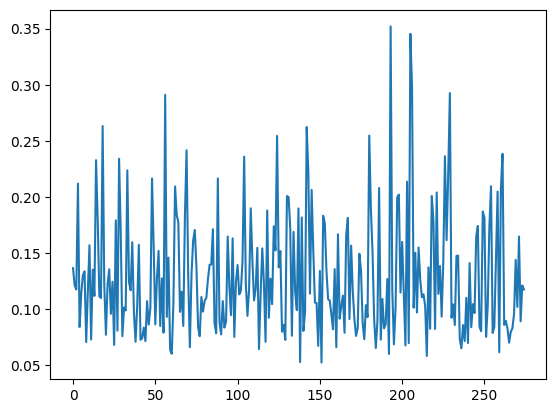

In [61]:
plt.plot(np.arange(test_x_norm.shape[0]), dist1)

In [62]:
def quantization_error(data, som):
    total_error = 0.0
    for row in data:
        distance_map = np.sqrt(np.sum((som-row)**2, axis=2))
        total_error += distance_map.min()
    quantization_err = total_error / data.shape[0]
    return quantization_err

def quantization_error_broadcasted(data, som):
    som_bro = som[:,:,:,np.newaxis]
    data_bro = data.T[np.newaxis,np.newaxis, :, :]
    distance_map = np.sqrt(np.sum((som_bro-data_bro)**2, axis=2))
    total_error = np.min(distance_map, axis=(0,1)).sum()
    quantization_err = total_error / data.shape[0]
    return quantization_err

In [63]:
training_qt_err=quantization_error(train_x_norm, som)
training_qt_err

0.07693295642453625

In [64]:
test_qt_error=quantization_error(test_x_norm, som)
test_qt_error

0.10363156930568049